In [ ]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from types import SimpleNamespace

# Silence TensorFlow, Abseil, cuDNN, and XLA compiler spam
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["ABSL_LOGGING_LEVEL"] = "fatal"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["XLA_FLAGS"] = "--xla_gpu_enable_triton_gemm=false"

import silence_tensorflow.auto

import tensorflow as tf
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
tf.get_logger().setLevel("ERROR")
tf.config.optimizer.set_jit(False)

import keras_hub


2025-10-21 11:51:50.219895: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-21 11:51:50.415210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761040310.534035  428598 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761040310.567636  428598 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761040310.772287  428598 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
args = SimpleNamespace(
    data_dir="data/artbench-10",
    img_size=(224, 224),
    batch_size=64,
    val_split=0.2,
    seed=42,
    epochs=200,
    lr_warmup=5e-4,
    lr_finetune=3e-5,
    preset="vit_large_patch16_224_imagenet21k",
    results_dir="results",
    warmup_epochs=5,
)

In [3]:
slurm_id = os.environ.get("SLURM_JOB_ID", "")
tag = f"_{slurm_id}" if slurm_id else ""
os.makedirs(args.results_dir, exist_ok=True)

# Seeds
tf.keras.utils.set_random_seed(args.seed)
random.seed(args.seed)
np.random.seed(args.seed)

In [4]:
augment = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomTranslation(height_factor=0.05, width_factor=0.05, fill_mode="reflect"),
        tf.keras.layers.RandomRotation(factor=0.05, fill_mode="reflect"),
        tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode="reflect"),
        tf.keras.layers.RandomContrast(factor=0.1),
    ],
    name="augment",
)

2025-10-21 11:51:53.583004: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1761040313.583998  428598 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43500 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:21:00.0, compute capability: 8.9


In [5]:
def plot_history(history):
    hist = history.history
    xx = np.arange(1, len(hist["loss"]) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    plt.subplots_adjust(wspace=0.3)

    ax = axs[0]; ax.grid(True); ax.set_ylabel("loss")
    ax.plot(xx, hist["loss"], "b-", label="loss")
    ax.plot(xx, hist["val_loss"], "r-", label="val_loss")
    ax.legend(loc="best")

    ax = axs[1]; ax.grid(True); ax.set_ylabel("accuracy")
    ax.plot(xx, hist["accuracy"], "b-", label="accuracy")
    ax.plot(xx, hist["val_accuracy"], "r-", label="val_accuracy")
    ax.legend(loc="best")

    for ax in axs:
        ax.set_xlabel("epoch")
    plt.show()

def plot_confusion_matrix(cm, classes, normalize=True):
    if normalize:
        cm = cm.astype("float") / (cm.sum(axis=1, keepdims=True) + 1e-12)

    plt.figure(figsize=(5.5, 4.5))
    plt.imshow(cm, interpolation="nearest", cmap="viridis")
    plt.title("Confusion matrix" + (" (normalized)" if normalize else ""))
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = format(cm[i, j], fmt)
            plt.text(j, i, val,
                     ha="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=7)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

def merge_histories(H_list):
    merged = {}
    for H in H_list:
        for k, v in H.history.items():
            merged.setdefault(k, [])
            merged[k].extend(v)
    class _Hist:
        def __init__(self, hist):
            self.history = hist
    return _Hist(merged)

In [6]:
def build_datasets(data_dir, img_size, batch_size, val_split, seed):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(data_dir, "train"),
        validation_split=val_split,
        subset="training",
        seed=seed,
        image_size=tuple(img_size),
        batch_size=batch_size,
        label_mode="int",
        shuffle=True,
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(data_dir, "train"),
        validation_split=val_split,
        subset="validation",
        seed=seed,
        image_size=tuple(img_size),
        batch_size=batch_size,
        label_mode="int",
        shuffle=False,
    )
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(data_dir, "test"),
        image_size=tuple(img_size),
        batch_size=batch_size,
        label_mode="int",
        shuffle=False,
    )
    class_names = train_ds.class_names
    num_classes = len(class_names)
    return train_ds, val_ds, test_ds, class_names, num_classes

# Build datasets
train_raw, val_raw, test_raw, class_names, num_classes = build_datasets(
    args.data_dir, args.img_size, args.batch_size, args.val_split, args.seed
)
print(f"Classes ({num_classes}):", class_names)

Found 50000 files belonging to 10 classes.


Using 40000 files for training.


Found 50000 files belonging to 10 classes.


Using 10000 files for validation.


Found 10000 files belonging to 10 classes.


Classes (10): ['art_nouveau', 'baroque', 'expressionism', 'impressionism', 'post_impressionism', 'realism', 'renaissance', 'romanticism', 'surrealism', 'ukiyo_e']


In [7]:
preproc = keras_hub.models.ViTImageClassifierPreprocessor.from_preset(args.preset)
clf = keras_hub.models.Backbone.from_preset(args.preset)
M = keras_hub.models.ViTImageClassifier(
    backbone=clf,
    num_classes=num_classes,
    preprocessor=preproc,
    activation="softmax",
    dropout=0.2,
)

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_raw.map(lambda x,y: (augment(x, training=True), y), 
                         num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds   = val_raw.prefetch(AUTOTUNE)
test_ds  = test_raw.prefetch(AUTOTUNE)

In [9]:
acc_metric = tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")
top5_metric = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5")

reduce_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.4, patience=6, verbose=0
)
early_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=12, restore_best_weights=True, verbose=0
)

In [10]:
warmup_epochs = max(1, min(args.warmup_epochs, args.epochs))
print(f"Warmup epochs (frozen backbone): {warmup_epochs}")

# Warmup
clf.trainable = False
M.compile(optimizer=tf.keras.optimizers.Adam(args.lr_warmup),
          loss="sparse_categorical_crossentropy",
          metrics=[acc_metric, top5_metric])
H1 = M.fit(train_ds, validation_data=val_ds, epochs=warmup_epochs, verbose=0)

Warmup epochs (frozen backbone): 5


I0000 00:00:1761040333.526750  428670 service.cc:152] XLA service 0x70ab5c002200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761040333.526857  428670 service.cc:160]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9


2025-10-21 11:52:13.968825: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


I0000 00:00:1761040340.038614  428670 cuda_dnn.cc:529] Loaded cuDNN version 91400


2025-10-21 11:52:24.168136: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 196 bytes spill stores, 196 bytes spill loads

2025-10-21 11:52:24.358751: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 344 bytes spill stores, 344 bytes spill loads



2025-10-21 11:52:24.434118: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 416 bytes spill stores, 416 bytes spill loads

2025-10-21 11:52:24.555511: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 560 bytes spill stores, 500 bytes spill loads

2025-10-21 11:52:24.561040: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 1044 bytes spill stores, 1044 bytes spill loads

2025-10-21 11:52:24.578135: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 188 bytes spill stores, 188 bytes spill loads

2025-10-21 11:52:24.611468: I external/local_x

2025-10-21 11:52:24.644860: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 560 bytes spill stores, 500 bytes spill loads

2025-10-21 11:52:24.664667: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 712 bytes spill stores, 712 bytes spill loads

2025-10-21 11:52:24.666326: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 476 bytes spill stores, 448 bytes spill loads

2025-10-21 11:52:24.680730: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 184 bytes spill stores, 184 bytes spill loads

2025-10-21 11:52:24.788639: I external/local

2025-10-21 11:52:24.895091: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_192', 444 bytes spill stores, 368 bytes spill loads

2025-10-21 11:52:24.898899: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 580 bytes spill stores, 440 bytes spill loads

2025-10-21 11:52:24.916119: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 628 bytes spill stores, 568 bytes spill loads

2025-10-21 11:52:24.920929: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 612 bytes spill stores, 548 bytes spill loads

2025-10-21 11:52:25.019443: I external/loc

2025-10-21 11:52:25.099047: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_192', 356 bytes spill stores, 308 bytes spill loads

2025-10-21 11:52:25.109433: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_192', 16 bytes spill stores, 16 bytes spill loads

2025-10-21 11:52:25.110818: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 1368 bytes spill stores, 1368 bytes spill loads

2025-10-21 11:52:25.126133: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 348 bytes spill stores, 348 bytes spill loads

2025-10-21 11:52:25.132124: I external/l

2025-10-21 11:52:25.323381: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 660 bytes spill stores, 504 bytes spill loads

2025-10-21 11:52:25.324319: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 852 bytes spill stores, 852 bytes spill loads

2025-10-21 11:52:25.400491: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 1368 bytes spill stores, 1368 bytes spill loads

2025-10-21 11:52:25.421086: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 636 bytes spill stores, 484 bytes spill loads

2025-10-21 11:52:25.435442: I external/local

2025-10-21 11:52:25.563834: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 4944 bytes spill stores, 4936 bytes spill loads

2025-10-21 11:52:25.694788: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 7500 bytes spill stores, 7496 bytes spill loads



2025-10-21 11:52:25.809801: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 8604 bytes spill stores, 8600 bytes spill loads

2025-10-21 11:52:25.874866: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 7128 bytes spill stores, 7096 bytes spill loads



I0000 00:00:1761040349.261165  428670 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2025-10-21 11:54:56.924383: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 184 bytes spill stores, 184 bytes spill loads

2025-10-21 11:54:57.097602: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 4944 bytes spill stores, 4936 bytes spill loads



2025-10-21 11:54:57.160634: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_193', 608 bytes spill stores, 540 bytes spill loads

2025-10-21 11:54:57.208116: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_193', 4932 bytes spill stores, 4924 bytes spill loads



2025-10-21 11:54:57.601436: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_193', 8632 bytes spill stores, 8632 bytes spill loads



2025-10-21 11:54:57.856899: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_193', 184 bytes spill stores, 184 bytes spill loads

2025-10-21 11:54:57.871903: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 348 bytes spill stores, 348 bytes spill loads

2025-10-21 11:54:57.873515: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 476 bytes spill stores, 448 bytes spill loads

2025-10-21 11:54:57.907134: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_240', 16 bytes spill stores, 16 bytes spill loads

2025-10-21 11:54:57.936262: I external/loc

2025-10-21 11:54:58.295149: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_193', 356 bytes spill stores, 356 bytes spill loads

2025-10-21 11:54:58.437817: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_240', 356 bytes spill stores, 308 bytes spill loads

2025-10-21 11:54:58.461319: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 852 bytes spill stores, 852 bytes spill loads

2025-10-21 11:54:58.481514: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 636 bytes spill stores, 484 bytes spill loads

2025-10-21 11:54:58.487316: I external/l

2025-10-21 11:54:58.521102: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_193', 840 bytes spill stores, 840 bytes spill loads

2025-10-21 11:54:58.541634: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 560 bytes spill stores, 500 bytes spill loads

2025-10-21 11:54:58.555817: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_240', 500 bytes spill stores, 420 bytes spill loads

2025-10-21 11:54:58.563640: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_193', 1360 bytes spill stores, 1360 bytes spill loads

2025-10-21 11:54:58.567319: I extern

2025-10-21 11:54:58.764135: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_240', 444 bytes spill stores, 368 bytes spill loads

2025-10-21 11:54:58.765876: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 628 bytes spill stores, 568 bytes spill loads



2025-10-21 11:54:59.044448: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_193', 5248 bytes spill stores, 5244 bytes spill loads



In [11]:
# Fine tune
print(f"Fine-tune epochs (unfrozen backbone): {args.epochs - warmup_epochs}")
clf.trainable = True
M.compile(optimizer=tf.keras.optimizers.Adam(args.lr_finetune),
          loss="sparse_categorical_crossentropy",
          metrics=[acc_metric, top5_metric])
H2 = M.fit(train_ds, validation_data=val_ds,
           initial_epoch=warmup_epochs, epochs=args.epochs,
           callbacks=[reduce_cb, early_cb], verbose=0)

Fine-tune epochs (unfrozen backbone): 195


2025-10-21 12:04:39.308561: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_650', 24 bytes spill stores, 24 bytes spill loads

2025-10-21 12:04:39.348606: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_651', 36 bytes spill stores, 36 bytes spill loads



2025-10-21 12:04:39.889065: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_650', 20 bytes spill stores, 20 bytes spill loads



2025-10-21 12:04:40.185974: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 312 bytes spill stores, 280 bytes spill loads

2025-10-21 12:04:40.335393: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 960 bytes spill stores, 964 bytes spill loads

2025-10-21 12:04:40.380552: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_649', 156 bytes spill stores, 132 bytes spill loads



2025-10-21 12:04:40.672103: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_649', 224 bytes spill stores, 224 bytes spill loads

2025-10-21 12:04:40.806618: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_651', 612 bytes spill stores, 612 bytes spill loads



2025-10-21 12:04:40.917377: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_649', 72 bytes spill stores, 72 bytes spill loads

2025-10-21 12:04:40.956842: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_651', 160 bytes spill stores, 160 bytes spill loads

2025-10-21 12:04:40.999810: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_649', 220 bytes spill stores, 184 bytes spill loads



2025-10-21 12:04:41.336376: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 5812 bytes spill stores, 5804 bytes spill loads

2025-10-21 12:04:41.414560: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_651', 612 bytes spill stores, 612 bytes spill loads



2025-10-21 12:04:41.623877: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 184 bytes spill stores, 184 bytes spill loads

2025-10-21 12:04:41.713472: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_650', 88 bytes spill stores, 88 bytes spill loads



2025-10-21 12:04:41.836378: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_651', 1136 bytes spill stores, 1136 bytes spill loads

2025-10-21 12:04:41.922223: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_649', 156 bytes spill stores, 136 bytes spill loads

2025-10-21 12:04:42.014033: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_651', 160 bytes spill stores, 160 bytes spill loads



2025-10-21 12:04:42.189287: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 456 bytes spill stores, 388 bytes spill loads

2025-10-21 12:04:42.339357: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_651', 140 bytes spill stores, 140 bytes spill loads



2025-10-21 12:04:42.417148: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_650', 204 bytes spill stores, 204 bytes spill loads

2025-10-21 12:04:42.453610: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_651', 600 bytes spill stores, 600 bytes spill loads

2025-10-21 12:04:42.545239: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_651', 224 bytes spill stores, 224 bytes spill loads

2025-10-21 12:04:42.570892: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_649', 224 bytes spill stores, 224 bytes spill loads

2025-10-21 12:04:42.600331: I extern

2025-10-21 12:04:42.633103: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 432 bytes spill stores, 368 bytes spill loads

2025-10-21 12:04:42.794129: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 348 bytes spill stores, 348 bytes spill loads

2025-10-21 12:04:42.811916: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 992 bytes spill stores, 992 bytes spill loads

2025-10-21 12:04:42.817250: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 136 bytes spill stores, 132 bytes spill loads



2025-10-21 12:04:42.835579: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 160 bytes spill stores, 160 bytes spill loads

2025-10-21 12:04:42.884436: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_650', 8064 bytes spill stores, 8024 bytes spill loads

2025-10-21 12:04:42.956457: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 5332 bytes spill stores, 5324 bytes spill loads

2025-10-21 12:04:42.956535: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_650', 924 bytes spill stores, 932 bytes spill loads



2025-10-21 12:04:43.465676: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_651', 2048 bytes spill stores, 2056 bytes spill loads



In [12]:
H = merge_histories([H1, H2])

# Evaluate
train_metrics = M.evaluate(train_ds, return_dict=True, verbose=0)
test_metrics  = M.evaluate(test_ds,  return_dict=True, verbose=0)

acc_train = float(train_metrics["accuracy"])
acc_test  = float(test_metrics["accuracy"])
top5_test = test_metrics.get("top5")

print(f"Train accuracy : {acc_train:.2%}")
print(f"Test accuracy  : {acc_test:.2%}")
print(f"Test top-5     : {top5_test:.2%}")

Train accuracy : 97.27%
Test accuracy  : 67.58%
Test top-5     : 97.22%


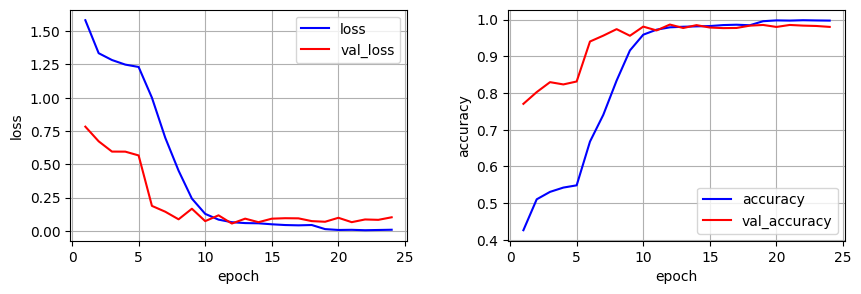

In [13]:
plot_history(H)

2025-10-21 14:34:19.467879: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


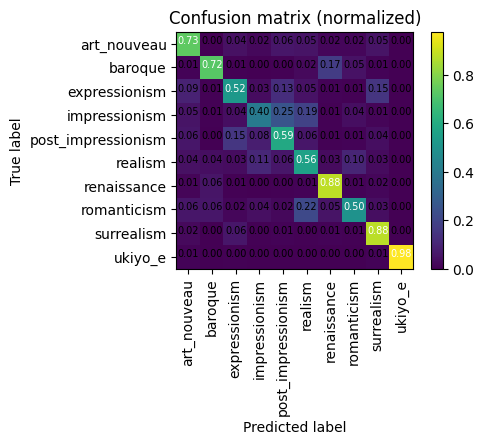

In [14]:
# True labels
y_true = []
for _, y in test_ds:
    y_true.append(y.numpy())
y_true = np.concatenate(y_true, axis=0)

# Predictions
y_pred = np.argmax(M.predict(test_ds, verbose=0), axis=1)

# Confusion matrix plot
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
plot_confusion_matrix(cm, class_names, normalize=True)

In [15]:
report = classification_report(
    y_true, y_pred, target_names=class_names, digits=3
)
print(report)

                    precision    recall  f1-score   support

       art_nouveau      0.669     0.735     0.701      1000
           baroque      0.810     0.723     0.764      1000
     expressionism      0.590     0.521     0.553      1000
     impressionism      0.575     0.399     0.471      1000
post_impressionism      0.520     0.588     0.552      1000
           realism      0.480     0.560     0.517      1000
       renaissance      0.742     0.879     0.805      1000
       romanticism      0.680     0.499     0.576      1000
        surrealism      0.712     0.877     0.786      1000
           ukiyo_e      0.993     0.977     0.985      1000

          accuracy                          0.676     10000
         macro avg      0.677     0.676     0.671     10000
      weighted avg      0.677     0.676     0.671     10000

